In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchviz import make_dot
from tqdm import tqdm

from utils.dataset import PreloadedDataset
from ipvae import iPVAE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

  0%|          | 0/50000 [00:00<?, ?it/s]

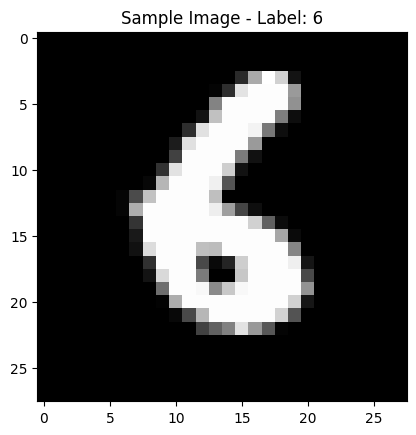

In [3]:
# Load the MNIST dataset
DATASET_ROOT = '../../datasets/'
mnist_train = datasets.MNIST(root=DATASET_ROOT, train=True, download=False, transform=torchvision.transforms.ToTensor())
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = datasets.MNIST(root=DATASET_ROOT, train=False, download=False, transform=torchvision.transforms.ToTensor())
train = PreloadedDataset.from_dataset(mnist_train, None, device, use_tqdm=True)
val = PreloadedDataset.from_dataset(mnist_val, None, device, use_tqdm=True)
test = PreloadedDataset.from_dataset(mnist_test, None, device, use_tqdm=True)

# Display a sample image from the dataset
sample_image, sample_label = mnist_train[0]
plt.imshow(sample_image.squeeze().cpu(), cmap='gray')
plt.title(f'Sample Image - Label: {sample_label}')
plt.show()


In [4]:
num_features = 128 # u/r/z dimensionality
alpha = 1.0 # u + alpha*du
mode='mlp' # 'mlp' or 'cnn'
T = 16 # Number of steps for the iP-VAE Inference
beta = 5.0 # Loss = Recon + beta*KL

num_epochs = 30 
learning_rate = 0.001
batch_size = 512

model = iPVAE(num_features=num_features, alpha=alpha, mode=mode).to(device)
# model = torch.compile(model, mode='max-autotune')
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

train_losses_recon = []
train_losses_kl = []
train_losses = []
val_losses_recon = []
val_losses_kl = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss_recon = 0
    train_loss_kl = 0
    train_loss = 0

    num_batches = 0
    loop = tqdm(train_loader, leave=False)
    if epoch > 0:
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.3e} - KL: {train_losses_kl[-1]:.3e} - Train MSE: {train_losses_recon[-1]:.3e} - Val MSE: {val_losses_recon[-1]:.3e}')
    for images, _ in loop:
        
        optimizer.zero_grad()
        _, losses_recon, losses_kl = model(images, T=T, losses=True)
        loss = sum(losses_recon) + beta*sum(losses_kl)
        loss.backward()
        optimizer.step()
        
        train_loss_recon += losses_recon[-1].item()
        train_loss_kl += losses_kl[-1].item()
        train_loss += loss.item()
        num_batches += 1

    train_loss_recon = train_loss_recon / num_batches
    train_loss_kl = train_loss_kl / num_batches
    train_loss = train_loss / num_batches

    model.eval()
    val_loss_recon = 0
    val_loss_kl = 0
    val_loss = 0
    num_batches = 0

    for images, _ in val_loader:
        _, losses_recon, losses_kl = model(images, T=T, losses=True)
        loss = sum(losses_recon) + beta*sum(losses_kl)
        val_loss_recon += losses_recon[-1].item()
        val_loss_kl += losses_kl[-1].item()
        val_loss += loss.item()
        num_batches += 1
    
    val_loss_recon = val_loss_recon / num_batches
    val_loss_kl = val_loss_kl / num_batches
    val_loss = val_loss / num_batches

    train_losses_kl.append(train_loss_kl)
    train_losses_recon.append(train_loss_recon)
    train_losses.append(train_loss)
    val_losses_kl.append(val_loss_kl)
    val_losses_recon.append(val_loss_recon)
    val_losses.append(val_loss)

print(f'Finished Training')
print(f'Best loss: {min(train_losses)}')
print(f'Final reconstruction loss: {train_losses_recon[-1]:.3e}')
print(f'Final KL loss: {train_losses_kl[-1]:.3e}')


Finished Training
Best loss: 509.40390699736923
Final reconstruction loss: 1.848e+01
Final KL loss: 3.038e-01


In [6]:
# Save the model
model_name = f'{mode}-{num_features}D-{alpha}a-{T}T-{beta}b'
torch.save(model.state_dict(), f'models/{model_name}.pth')

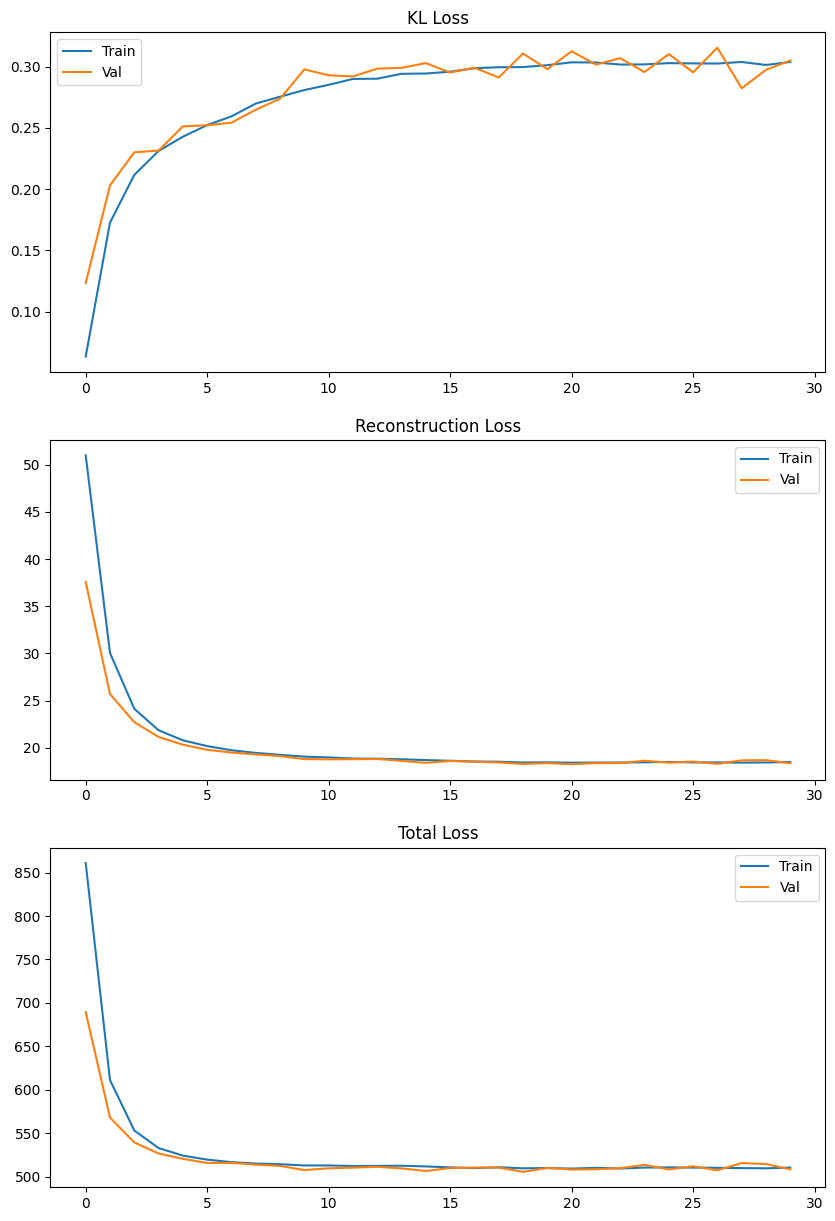

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(train_losses_kl, label='Train')
axs[0].plot(val_losses_kl, label='Val')
axs[0].set_title('KL Loss')
axs[1].plot(train_losses_recon, label='Train')
axs[1].plot(val_losses_recon, label='Val')
axs[1].set_title('Reconstruction Loss')
axs[2].plot(train_losses, label='Train')
axs[2].plot(val_losses, label='Val')
axs[2].set_title('Total Loss')
for ax in axs.flatten():
    ax.legend()
plt.show()

torch.Size([10, 784])


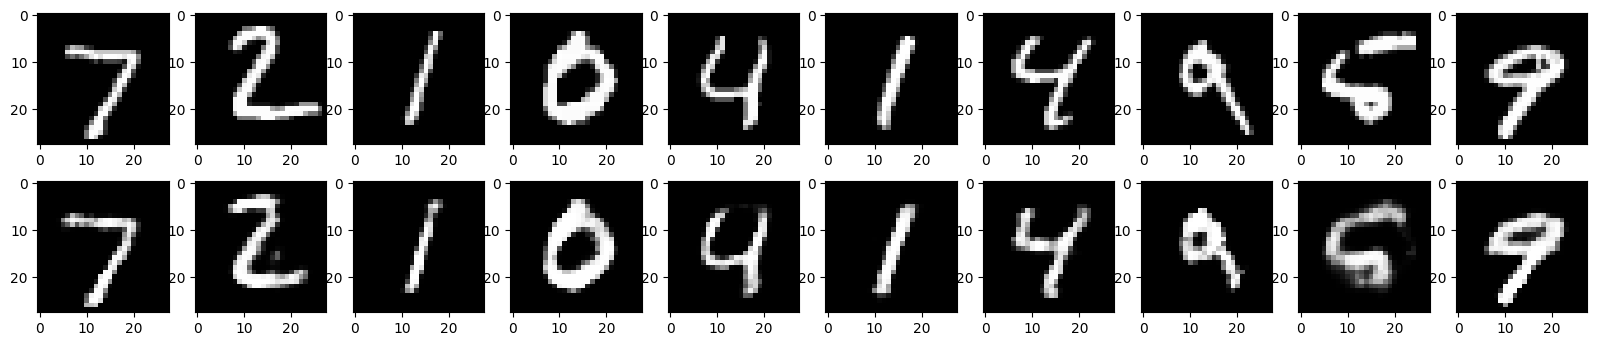

In [6]:
x = test.images[:10]
z = model(x, T=1000)
preds = model.decoder(z)
print(preds.shape)
if preds.dim() == 2:
    preds = preds.reshape(preds.shape[0], 1, 28, 28)
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x[i].squeeze().cpu(), cmap='gray')
    axs[1, i].imshow(preds[i].squeeze().detach().cpu(), cmap='gray')
plt.show()

torch.Size([10, 784])


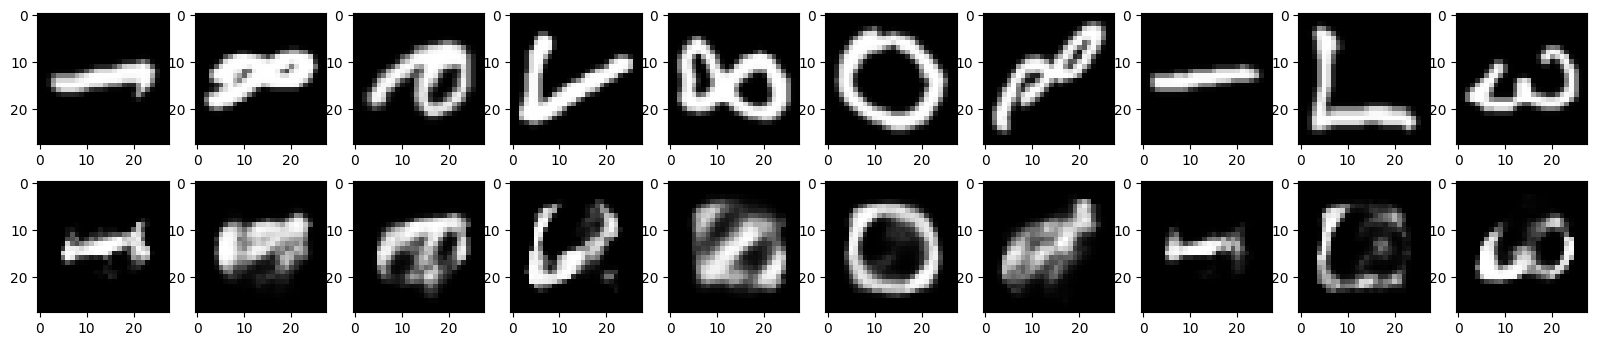

In [17]:
# Load the EMNIST 'MNIST' dataset
# emnist_train = datasets.EMNIST(root=DATASET_ROOT, split='mnist', train=True, download=True, transform=torchvision.transforms.ToTensor())
# etrain = PreloadedDataset.from_dataset(emnist_train, None, device, use_tqdm=True)
emnist_test = datasets.EMNIST(root=DATASET_ROOT, split='mnist', train=False, download=True, transform=torchvision.transforms.ToTensor())
etest = PreloadedDataset.from_dataset(emnist_test, None, device, use_tqdm=True)

model.eval()
x = etest.images[:10]
z = model(x, T=1000)
preds = model.decoder(z)
print(preds.shape)
if preds.dim() == 2:
    preds = preds.reshape(preds.shape[0], 1, 28, 28)
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x[i].squeeze().cpu(), cmap='gray')
    axs[1, i].imshow(preds[i].squeeze().detach().cpu(), cmap='gray')
plt.show()

torch.Size([10, 784])


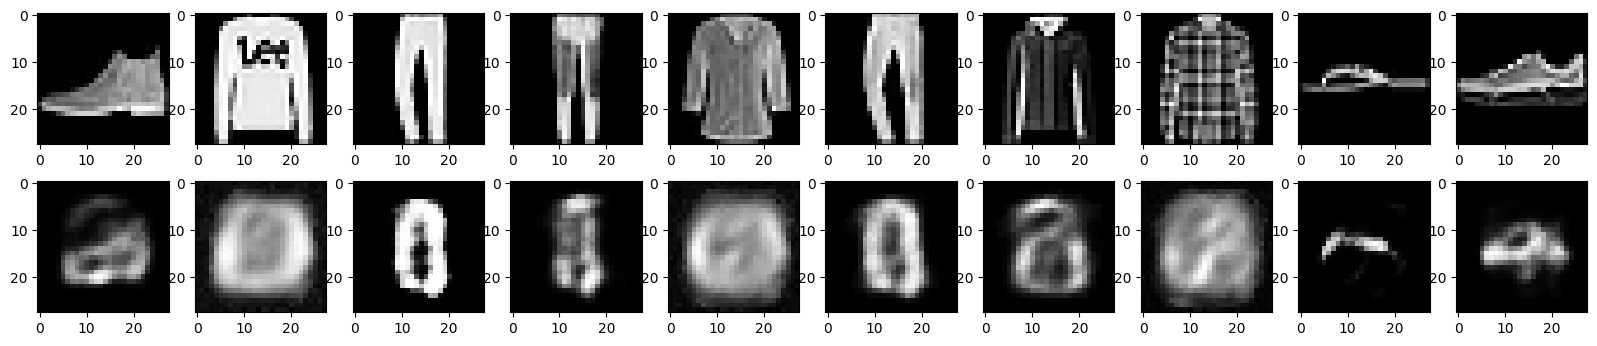

In [18]:
# Load the FashionMNIST dataset
# fashion_train = datasets.FashionMNIST(root=DATASET_ROOT, train=True, download=True, transform=torchvision.transforms.ToTensor())
# ftrain = PreloadedDataset.from_dataset(fashion_train, None, device, use_tqdm=True)
fashion_test = datasets.FashionMNIST(root=DATASET_ROOT, train=False, download=True, transform=torchvision.transforms.ToTensor())
ftest = PreloadedDataset.from_dataset(fashion_test, None, device, use_tqdm=True)

model.eval()
x = ftest.images[:10]
z = model(x, T=1000)
preds = model.decoder(z)
print(preds.shape)
if preds.dim() == 2:
    preds = preds.reshape(preds.shape[0], 1, 28, 28)
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x[i].squeeze().cpu(), cmap='gray')
    axs[1, i].imshow(preds[i].squeeze().detach().cpu(), cmap='gray')
plt.show()